In [25]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

In [2]:

url = 'https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes'
page = requests.get(url)
soup = BeautifulSoup(page.text, 'lxml')
table1 = soup.find("table")

elements = list()
mydata = pd.DataFrame(columns = ['Country', 'code'])
for j in table1.find_all("tr")[2:]:
    row_data = j.find_all("td")
    row = [i.text for i in row_data]
    if len(row) >1:
        elements.append((row[0], row[3]))
    else:
       pass


cleaned_data = [(t[0].replace('\n', '').replace('\xa0', '').replace('\u200a[b]', '').replace('\u200a[aj]', '').replace('\u200a[c]', ''), t[1].replace('\n', '')) for t in elements]
country_codes = pd.DataFrame(cleaned_data, columns=['Country', 'Code'])
codes_list = list(country_codes['Code'])

In [3]:
country_data = list()
for code in codes_list:
    url = 'https://pris.iaea.org/PRIS/CountryStatistics/CountryDetails.aspx?current=' + f'{code}'
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html.parser')
    table1 = soup.find_all("table")
    headers = []
    if table1 == None or len(table1) == 0:
        pass
    else:
        table1 = table1[-2]
        for i in table1.find_all("th"):
            title = i.text
            headers.append(title)
        mydata = pd.DataFrame(columns = headers)
        for j in table1.find_all("tr")[1:]:
            row_data = j.find_all("td")
            row = [i.text for i in row_data]
            length = len(mydata.axes[0])
            mydata.loc[length] = row

            mydata.columns = mydata.columns.str.strip().str.replace('\r\n', '').str.replace('\[.*\]', '').str.strip()
        mydata['country code'] = code
        country_data.append(mydata)


combined = pd.concat(country_data, ignore_index = True)
combined = combined.apply(lambda x: x.str.strip().str.replace(r'[\r\n]+', '', regex=True))

C:\Users\a-spyrosploussiou\AppData\Local\Temp\158\ipykernel_44480\831697438.py:22: FutureWarning: The default value of regex will change from True to False in a future version.
  mydata.columns = mydata.columns.str.strip().str.replace('\r\n', '').str.replace('\[.*\]', '').str.strip()
C:\Users\a-spyrosploussiou\AppData\Local\Temp\158\ipykernel_44480\831697438.py:22: FutureWarning: The default value of regex will change from True to False in a future version.
  mydata.columns = mydata.columns.str.strip().str.replace('\r\n', '').str.replace('\[.*\]', '').str.strip()
C:\Users\a-spyrosploussiou\AppData\Local\Temp\158\ipykernel_44480\831697438.py:22: FutureWarning: The default value of regex will change from True to False in a future version.
  mydata.columns = mydata.columns.str.strip().str.replace('\r\n', '').str.replace('\[.*\]', '').str.strip()
C:\Users\a-spyrosploussiou\AppData\Local\Temp\158\ipykernel_44480\831697438.py:22: FutureWarning: The default value of regex will change from Tru

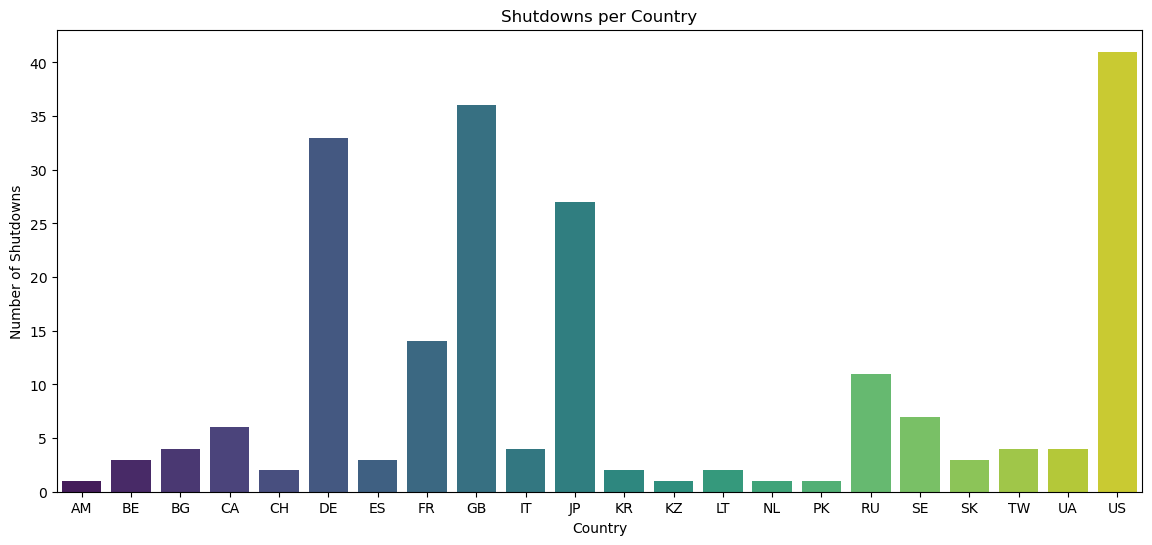

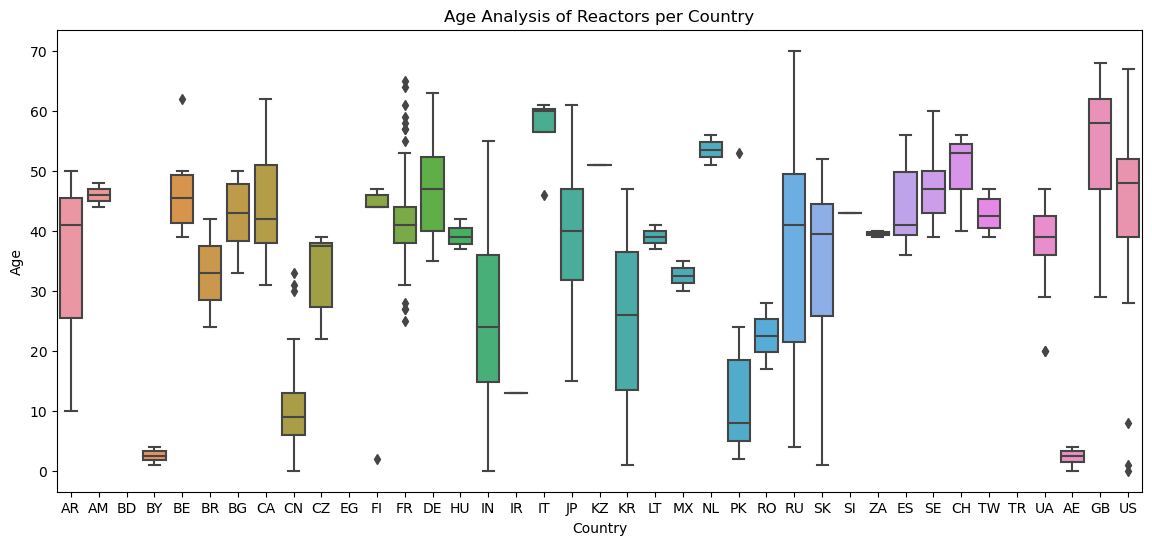

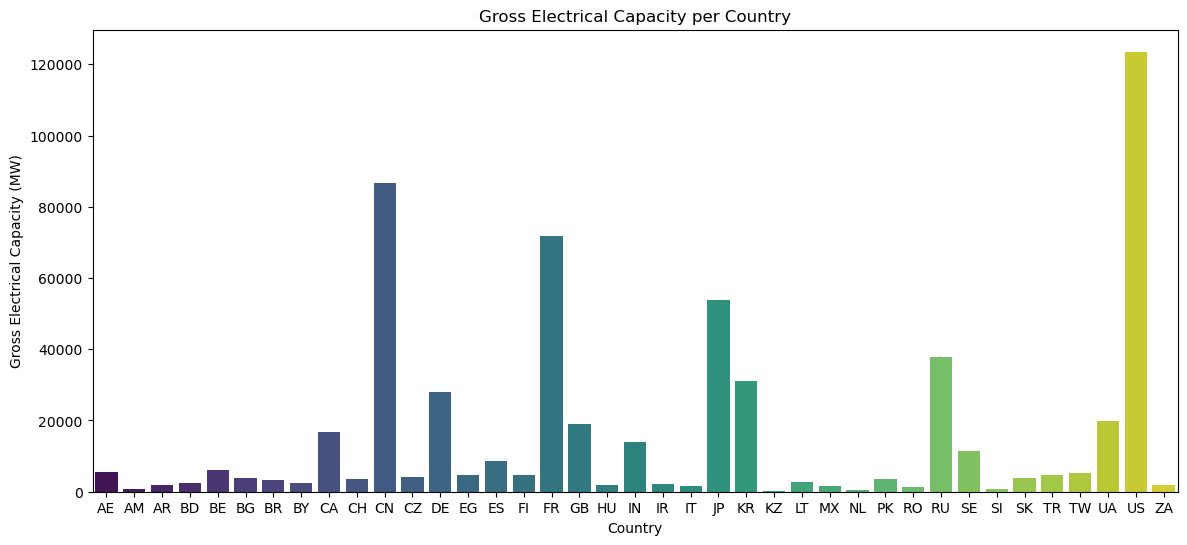

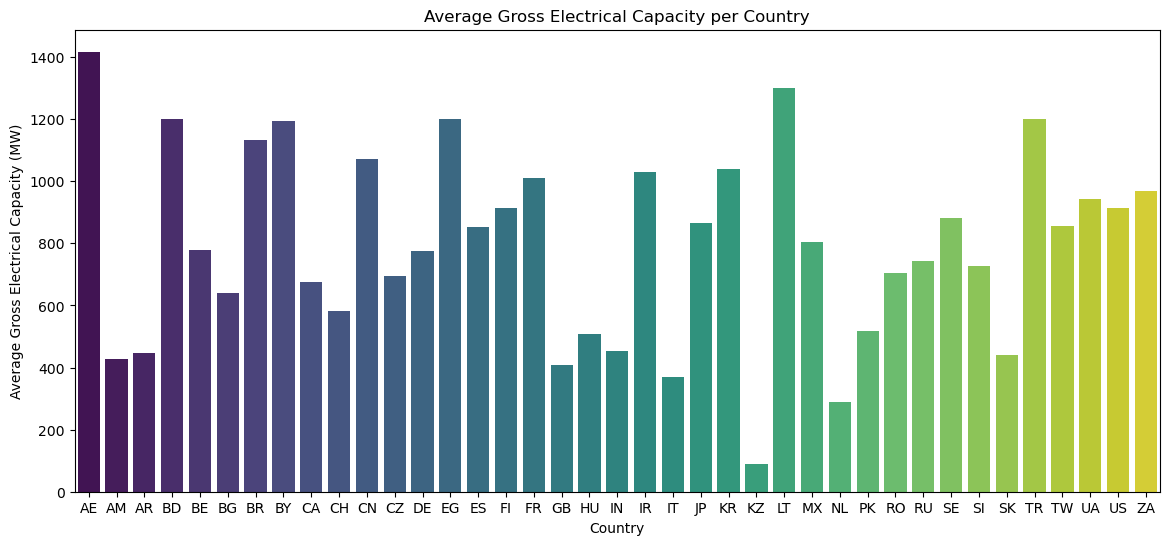

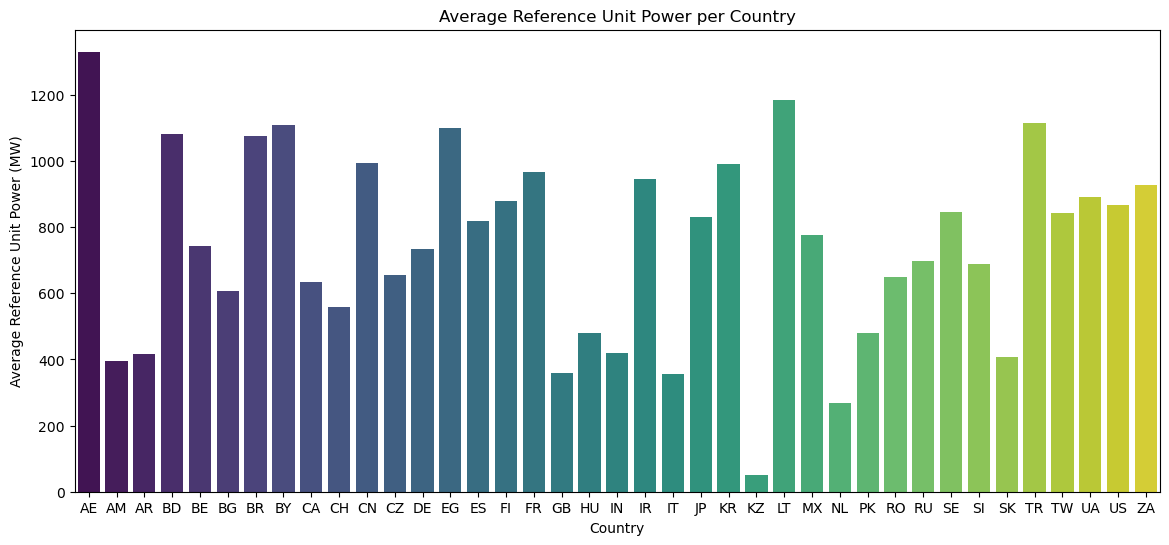

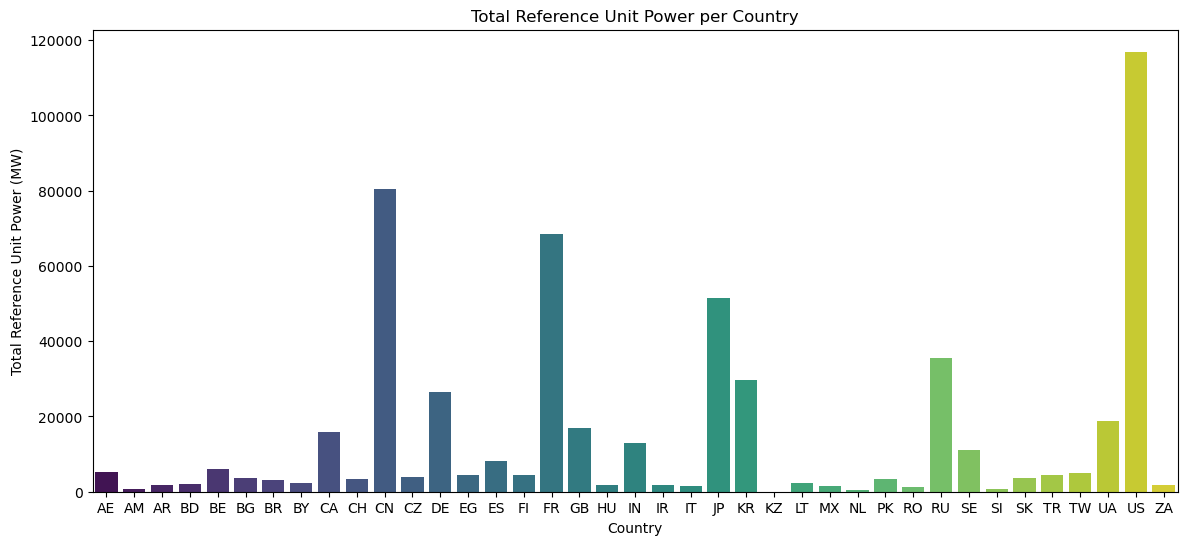

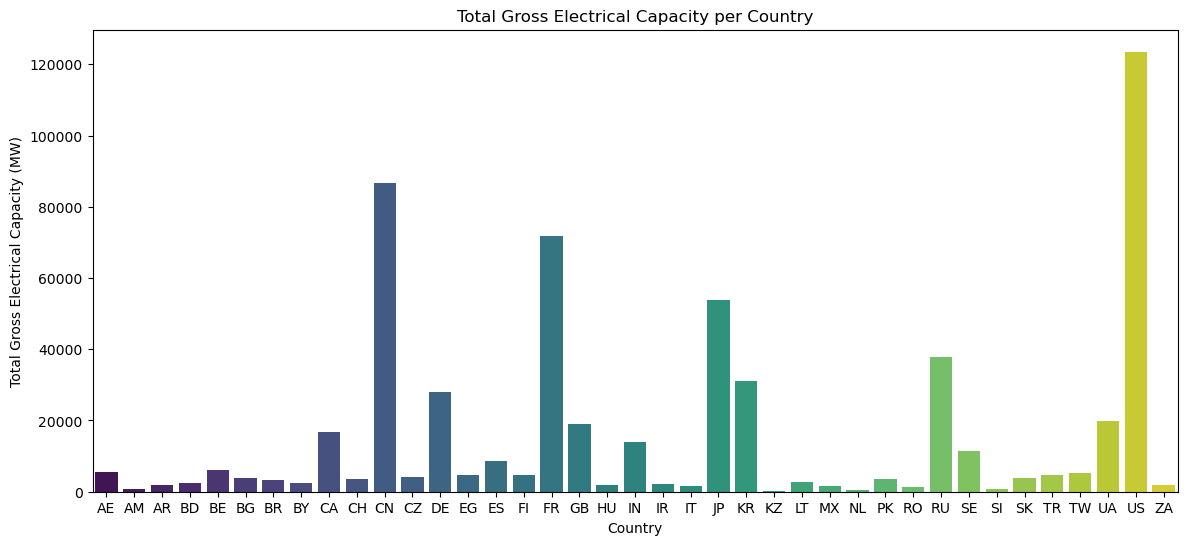

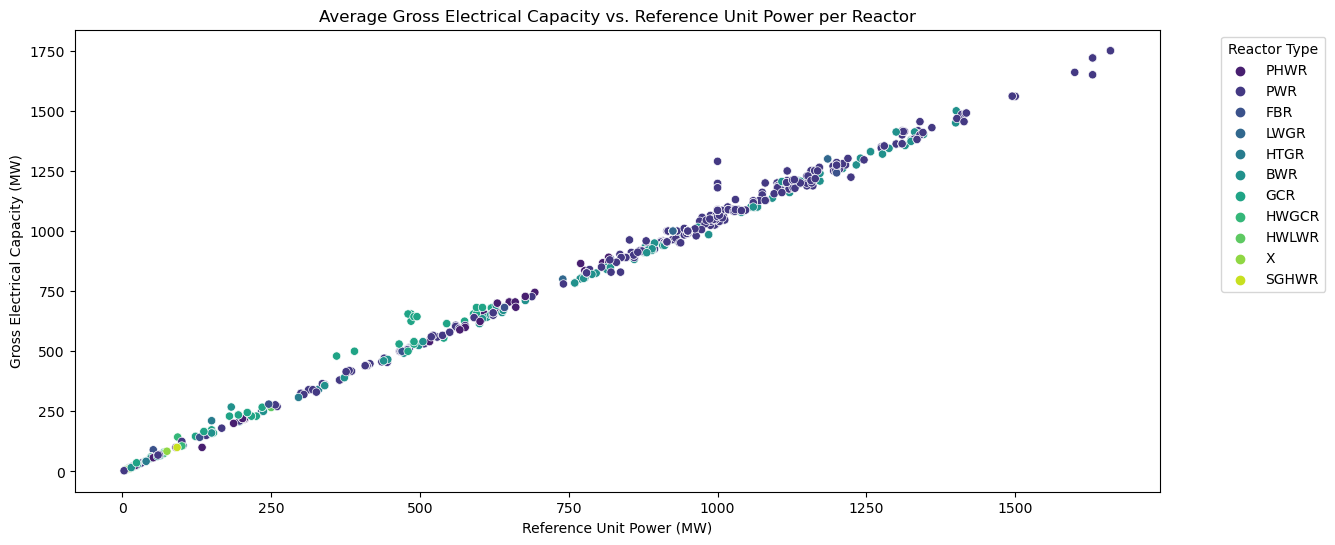

In [32]:
nuclear_data = combined.copy()

nuclear_data['First Grid Connection'] = pd.to_datetime(nuclear_data['First Grid Connection'], errors='coerce')

nuclear_data['Reference Unit Power'] = pd.to_numeric(nuclear_data['Reference Unit Power'], errors='coerce')
nuclear_data['Gross Electrical Capacity'] = pd.to_numeric(nuclear_data['Gross Electrical Capacity'], errors='coerce')

nuclear_data['Age'] = 2024 - nuclear_data['First Grid Connection'].dt.year

shutdowns_per_country = nuclear_data[nuclear_data['Status'] == 'Permanent Shutdown'].groupby('country code').size()

age_analysis_per_country = nuclear_data.groupby('country code')['Age'].mean()

gross_capacity_per_country = nuclear_data.groupby('country code')['Gross Electrical Capacity'].sum()

avg_gross_capacity_per_country = nuclear_data.groupby('country code')['Gross Electrical Capacity'].mean()
avg_ref_unit_power_per_country = nuclear_data.groupby('country code')['Reference Unit Power'].mean()

avg_gross_capacity_per_reactor = nuclear_data.groupby('Name')['Gross Electrical Capacity'].mean()
avg_ref_unit_power_per_reactor = nuclear_data.groupby('Name')['Reference Unit Power'].mean()

ref_unit_power_per_country = nuclear_data.groupby('country code')['Reference Unit Power'].sum()


plt.figure(figsize=(14, 6))
sns.barplot(x=shutdowns_per_country.index, y=shutdowns_per_country.values, palette="viridis")
plt.title('Shutdowns per Country')
plt.xlabel('Country')
plt.ylabel('Number of Shutdowns')
plt.show()

plt.figure(figsize=(14, 6))
sns.boxplot(x='country code', y='Age', data=nuclear_data)
plt.title('Age Analysis of Reactors per Country')
plt.xlabel('Country')
plt.ylabel('Age')
plt.show()

plt.figure(figsize=(14, 6))
sns.barplot(x=gross_capacity_per_country.index, y=gross_capacity_per_country.values, palette="viridis")
plt.title('Gross Electrical Capacity per Country')
plt.xlabel('Country')
plt.ylabel('Gross Electrical Capacity (MW)')
plt.show()

plt.figure(figsize=(14, 6))
sns.barplot(x=avg_gross_capacity_per_country.index, y=avg_gross_capacity_per_country.values, palette="viridis")
plt.title('Average Gross Electrical Capacity per Country')
plt.xlabel('Country')
plt.ylabel('Average Gross Electrical Capacity (MW)')
plt.show()

plt.figure(figsize=(14, 6))
sns.barplot(x=avg_ref_unit_power_per_country.index, y=avg_ref_unit_power_per_country.values, palette="viridis")
plt.title('Average Reference Unit Power per Country')
plt.xlabel('Country')
plt.ylabel('Average Reference Unit Power (MW)')
plt.show()

plt.figure(figsize=(14, 6))
sns.barplot(x=ref_unit_power_per_country.index, y=ref_unit_power_per_country.values, palette="viridis")
plt.title('Total Reference Unit Power per Country')
plt.xlabel('Country')
plt.ylabel('Total Reference Unit Power (MW)')
plt.show()

plt.figure(figsize=(14, 6))
sns.barplot(x=gross_capacity_per_country.index, y=gross_capacity_per_country.values, palette="viridis")
plt.title('Total Gross Electrical Capacity per Country')
plt.xlabel('Country')
plt.ylabel('Total Gross Electrical Capacity (MW)')
plt.show()

plt.figure(figsize=(14, 6))
sns.scatterplot(x=avg_ref_unit_power_per_reactor.values, y=avg_gross_capacity_per_reactor.values, hue=nuclear_data.set_index('Name').loc[avg_ref_unit_power_per_reactor.index]['Type'], palette="viridis")
plt.title('Average Gross Electrical Capacity vs. Reference Unit Power per Reactor')
plt.xlabel('Reference Unit Power (MW)')
plt.ylabel('Gross Electrical Capacity (MW)')
plt.legend(title='Reactor Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


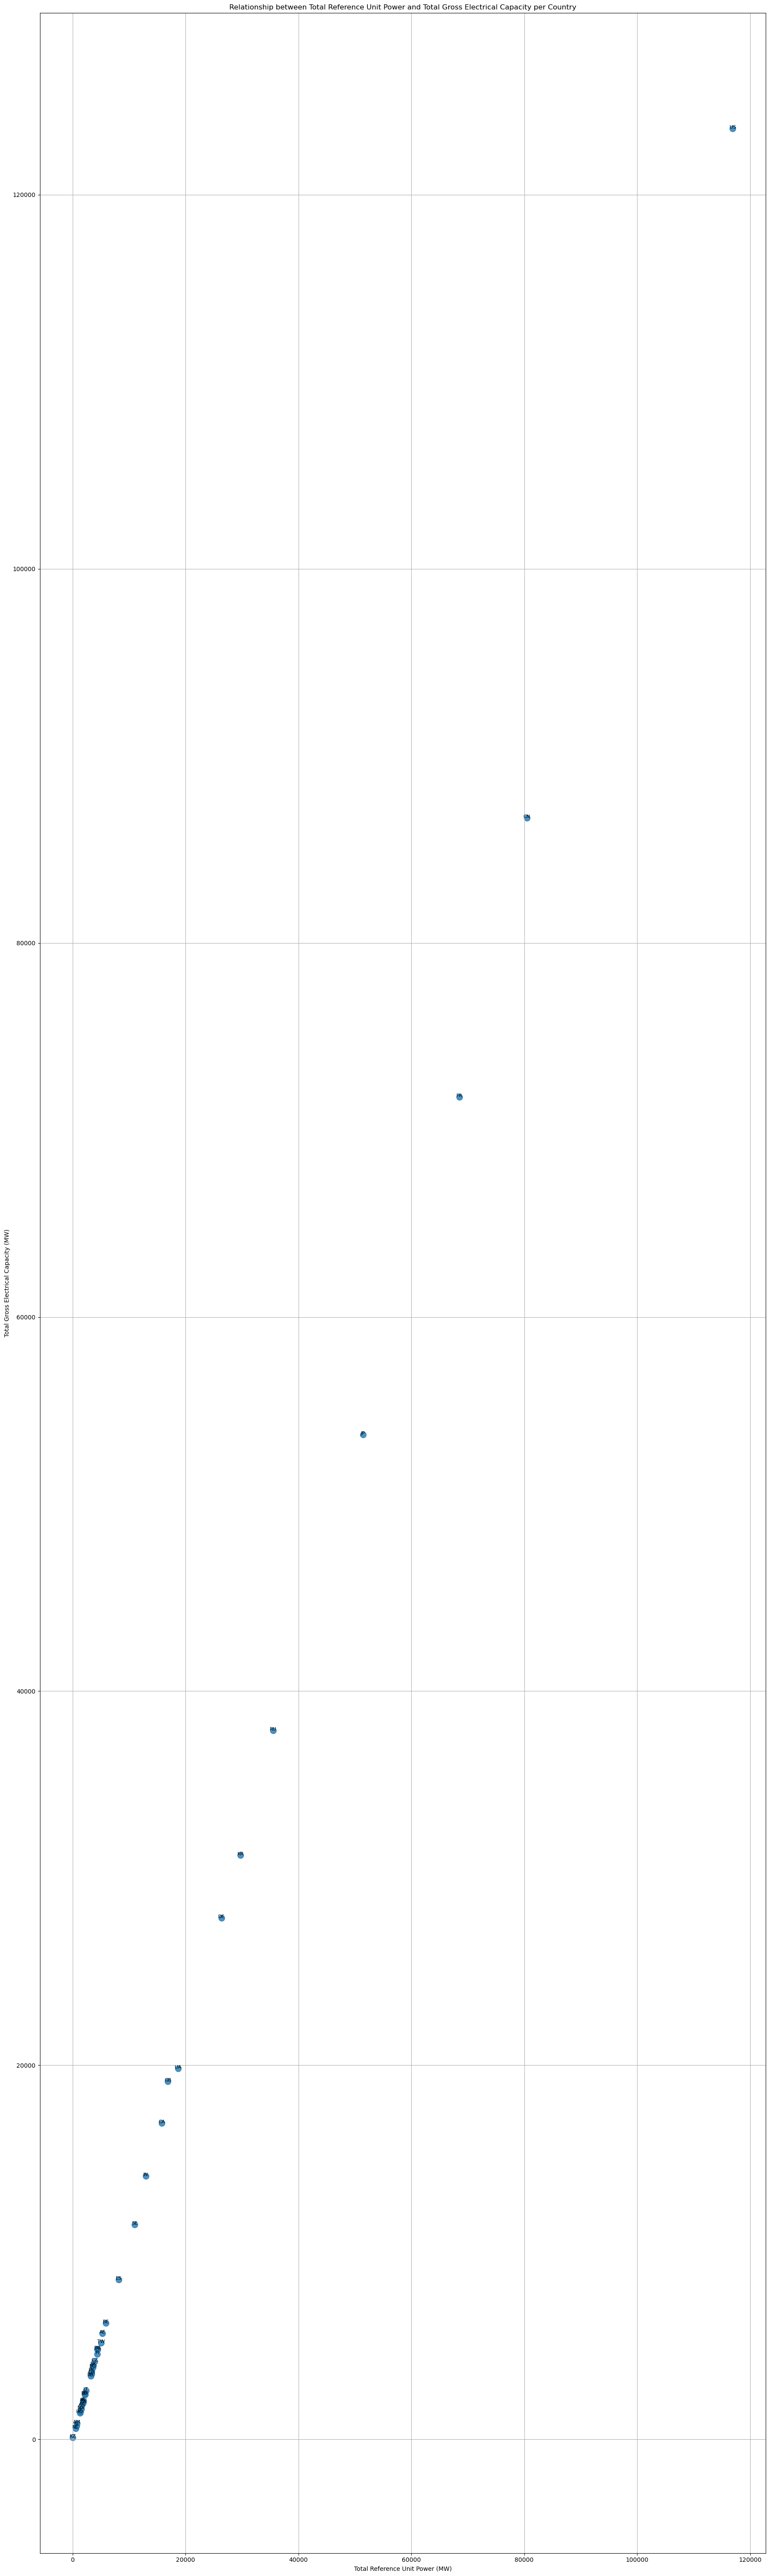

In [41]:
total_power_capacity = pd.DataFrame({
    'Total Reference Unit Power': ref_unit_power_per_country,
    'Total Gross Electrical Capacity': gross_capacity_per_country
})

plt.figure(figsize=(18, 60))
plt.scatter(total_power_capacity['Total Reference Unit Power'], total_power_capacity['Total Gross Electrical Capacity'], s=100, alpha=0.8)

for country, row in total_power_capacity.iterrows():
    plt.annotate(country, (row['Total Reference Unit Power'], row['Total Gross Electrical Capacity']), fontsize=8, ha='center')

plt.title('Relationship between Total Reference Unit Power and Total Gross Electrical Capacity per Country')
plt.xlabel('Total Reference Unit Power (MW)')
plt.ylabel('Total Gross Electrical Capacity (MW)')
plt.grid(True)
plt.tight_layout()
plt.show()


Root Mean Squared Error (RMSE): 20.27
Relative Root Mean Squared Error (rel RMSE): 0.00


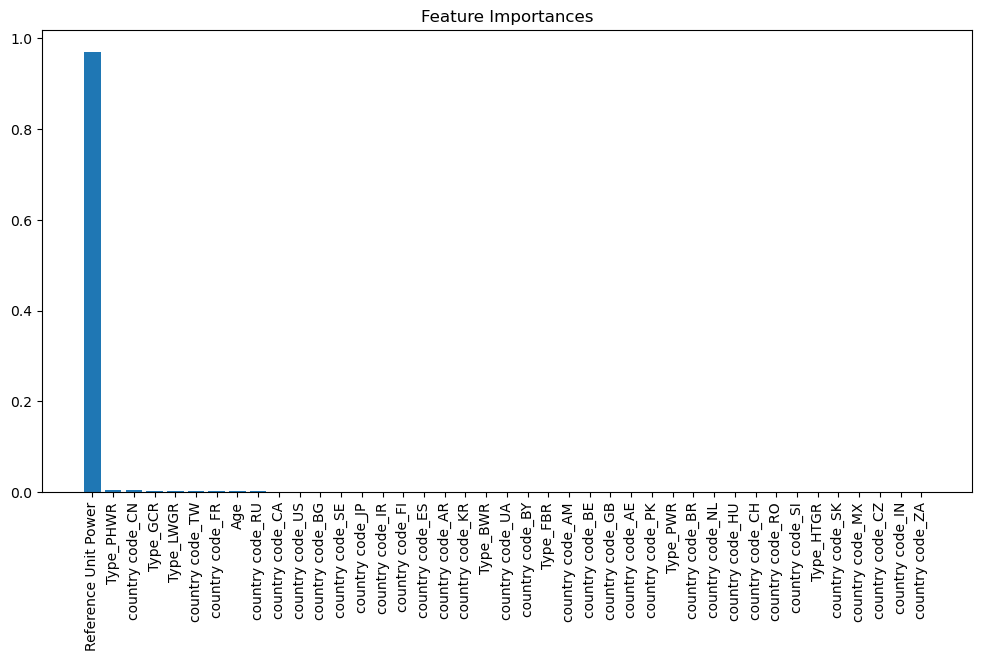

In [42]:
nuclear_data= combined.copy()

nuclear_data['First Grid Connection'] = pd.to_datetime(nuclear_data['First Grid Connection'], errors='coerce')

nuclear_data = nuclear_data[nuclear_data['Status'] == 'Operational']

nuclear_data['Reference Unit Power'] = pd.to_numeric(nuclear_data['Reference Unit Power'], errors='coerce')

nuclear_data['Age'] = 2024 - nuclear_data['First Grid Connection'].dt.year

nuclear_data = nuclear_data.drop(columns=['Name', 'Location', 'Status', 'First Grid Connection'])

nuclear_data = pd.get_dummies(nuclear_data, columns=['Type', 'country code'])

nuclear_data = nuclear_data.dropna()

X = nuclear_data.drop(columns=['Gross Electrical Capacity'])
y = nuclear_data['Gross Electrical Capacity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
relative_rmse = (rmse/y_test.mean())*100
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'Relative Root Mean Squared Error (rel RMSE): {relative_rmse:.2f}')

importances = model.feature_importances_
feature_names = X_train.columns
indices = np.argsort(importances)[::-1]

additional_keys = list()
for name in feature_names:
    if 'Type' in name or 'country code' in name:
        additional_keys.append(name)
    else:
        pass

plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.show()


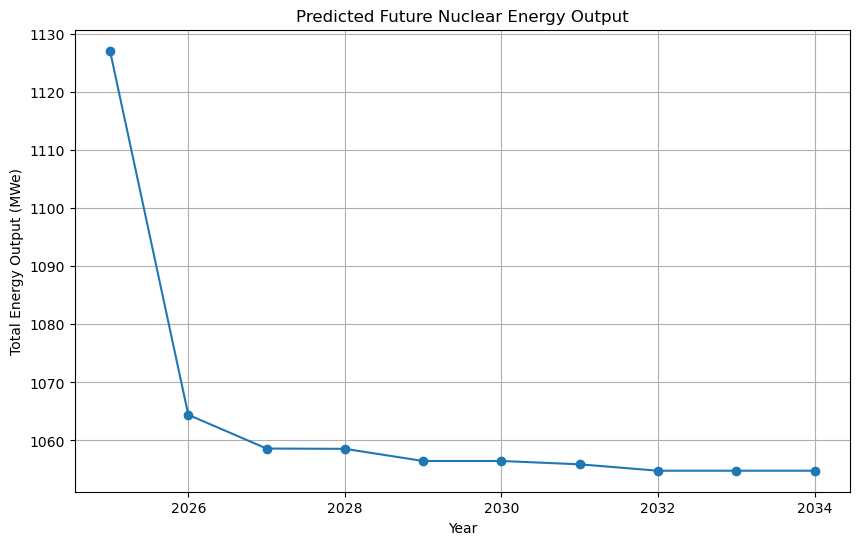

In [44]:
reactor = 'PWR'
country = 'US'

future_years = pd.DataFrame({
    'Reference Unit Power': [combined[(combined['country code'] == country) & (combined['Type'] == reactor)]['Reference Unit Power'].median()]*10,
    'Age': range(1, 11),  
})



for key in additional_keys:
    if 'Type' in key and not f'{reactor}'  in key:
        future_years[key] = [0]*10
    elif 'Type' in key and f'{reactor}' in key:
        future_years[key] = [1]*10
    elif 'country code' in key and not f'{country}' in key:
        future_years[key] = [0]*10 
    elif 'country code' in key and  f'{country}' in key:
        future_years[key] = [1]*10


for column in X_train.columns:
    if column not in future_years.columns:
        future_years[column] = 0

future_years = future_years[X_train.columns]


future_predictions = model.predict(future_years)

plt.figure(figsize=(10, 6))
plt.plot(range(2025, 2035), future_predictions, marker='o')
plt.title('Predicted Future Nuclear Energy Output')
plt.xlabel('Year')
plt.ylabel('Total Energy Output (MWe)')
plt.grid(True)
plt.show()
